In [22]:
import numpy as np
from matplotlib import pyplot as plt

from lib import Loads

In [23]:
solid1 = Loads.execute("data/entrada2.xls")

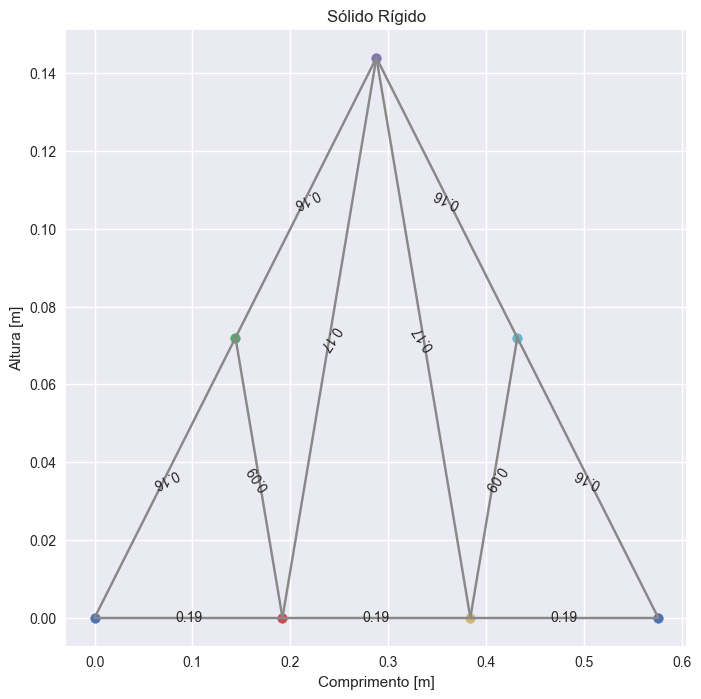

In [24]:
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(8, 8))

plt.title("Sólido Rígido")
plt.xlabel("Comprimento [m]")
plt.ylabel("Altura [m]")
solid1.plot()
plt.show()

In [25]:
mask_ = np.array([node.displacement.get_axis() for node in solid1.nodes]).flatten()
mask = np.bitwise_not(mask_)
mask

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False])

In [26]:
K = solid1.rigidity
K[mask][:, mask]

array([[ 1.36825619e+07, -3.69714935e+05, -3.60549794e+06,
         5.40824691e+06, -5.03853197e+06, -2.51926599e+06,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-3.69714935e+05,  1.06316363e+07,  5.40824691e+06,
        -8.11237036e+06, -2.51926599e+06, -1.25963299e+06,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-3.60549794e+06,  5.40824691e+06,  1.59705907e+07,
        -2.70412345e+06, -1.80274897e+06, -2.70412345e+06,
        -5.28117188e+06,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 5.40824691e+06, -8.11237036e+06, -2.70412345e+06,
         1.21685555e+07, -2.70412345e+06, -4.05618518e+06,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-5.03853197e+06, -2.51926599e+06, -1.80274897e+06,
        -2.70412345e+06,  1.36825619e+07,  4.65661287e-10,
  

In [27]:
F = []

for node in solid1.nodes:
    r = node.get_resultant_force()

    F.append(r.x)
    F.append(r.y)

F = np.array(F)
F[mask]

array([-1300., -1500.,     0.,     0., -1300., -1500.,     0.,     0.,
       -1300., -1500.,     0.])

In [28]:
from lib import GaussSeidel_Solver

displacements_masked = GaussSeidel_Solver.solve(K[mask][:, mask], F[mask], 1e-6)
displacements_masked

array([ 0.00100468, -0.00431158,  0.00035974, -0.00466295,  0.0002597 ,
       -0.00443911,  0.00055854, -0.00463741, -0.0003243 , -0.00424762,
        0.00116443])

## Deslocamento

In [29]:
displacements = np.zeros(K.shape[1])
displacements[mask] = displacements_masked

displacements

array([ 0.        ,  0.        ,  0.00100468, -0.00431158,  0.00035974,
       -0.00466295,  0.0002597 , -0.00443911,  0.00055854, -0.00463741,
       -0.0003243 , -0.00424762,  0.00116443,  0.        ])

## Reação de apoio

In [30]:
F[mask_] = np.matmul(K, displacements)[mask_]
F[mask_]

array([3900.03869981, 2899.9433855 , 1599.93596606])

## Deformações

In [31]:
deformations = []
tensions = []
forces = []

for beam in solid1.beams:
    i1 = (beam.node1.id - 1) * 2
    i2 = (beam.node2.id - 1) * 2
    u1 = displacements[i1:i1+2]
    u2 = displacements[i2:i2+2]

    deformation = beam.get_deformation(u1, u2)
    tension = deformation * beam.material.elasticity
    force = tension * beam.material.area

    deformations.append(deformation)
    tensions.append(tension)
    forces.append(force)

deformations

[-0.006395035962940141,
 -0.0044930306197962806,
 -0.0037763314960956103,
 -0.0035282233758450452,
 -0.0007556051691340126,
 0.0007555578648055818,
 0.0019112119696256535,
 -0.0019112255946432332,
 0.0018736451438589293,
 0.0010354027124043262,
 0.0031557106239678973]

## Tensões internas

In [32]:
tensions

[-1235137245.882259,
 -867783933.9074537,
 -729360665.1559062,
 -681441062.810712,
 -145937582.3665432,
 145928446.00855005,
 369131479.81349874,
 -369134111.3493941,
 361875823.0849136,
 199977679.87377158,
 609493949.9131597]

# Forcas internas

In [33]:
forces

[-6484.470540881859,
 -4555.865653014132,
 -3829.1434920685074,
 -3577.5655797562376,
 -766.1723074243517,
 766.1243415448877,
 1937.9402690208683,
 -1937.954084584319,
 1899.8480711957964,
 1049.8828193373008,
 3199.8432370440883]

# Gráfico da deformação

In [34]:
for beam in solid1.beams:
    i1 = (beam.node1.id - 1) * 2
    i2 = (beam.node2.id - 1) * 2

    beam.node1.x += displacements[i1]
    beam.node1.y += displacements[i1 + 1]
    beam.node2.x += displacements[i2]
    beam.node2.y += displacements[i2 + 1]

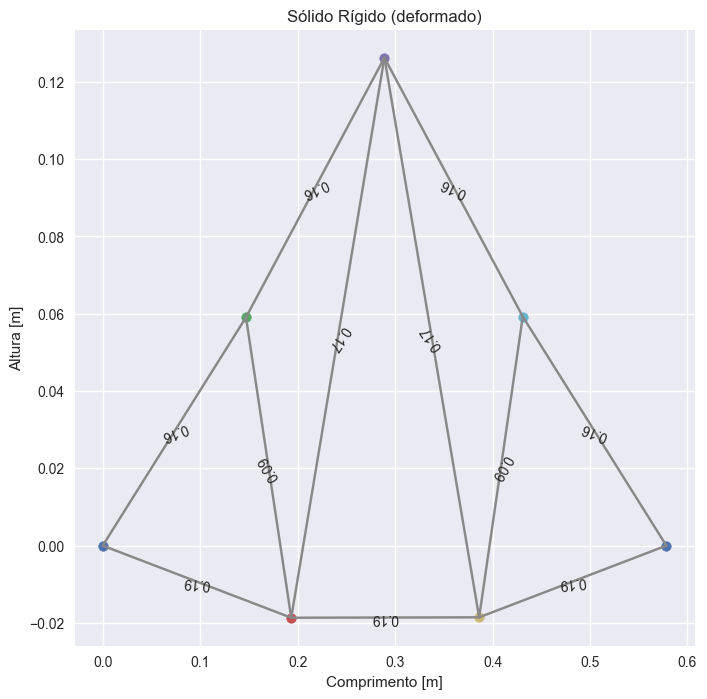

In [40]:
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(8, 8))

plt.title("Sólido Rígido (deformado)")
plt.xlabel("Comprimento [m]")
plt.ylabel("Altura [m]")
solid1.plot()
plt.savefig("saida.png", dpi=300, bbox_inches="tight")
plt.show()

# LISA

In [37]:
with open("solid1.liml", "w") as output:
    output.write(solid1.to_string())

In [38]:
from lib import geraSaida

geraSaida("saida", list(F[mask_]), list(displacements), list(deformations), list(forces), list(tensions))